# Transfer Learning mithilfe von Tensorflow bzw. Keras

von Eric Hirsch und Jonas Morsch


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf




In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importieren der Bilder mit "image_dataset_from_directory"

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
training_set = image_dataset_from_directory("Alle_Bilder",
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             batch_size=32,
                                             image_size=(150, 150),
                                             seed=1337,
                                             label_mode = 'categorical')

val_dataset = image_dataset_from_directory("Alle_Bilder",
                                                  shuffle=True,
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  batch_size=32,
                                                  image_size=(150, 150),
                                                  seed=1337,
                                                  label_mode = 'categorical')

Found 805 files belonging to 3 classes.
Using 644 files for training.
Found 805 files belonging to 3 classes.
Using 161 files for validation.


Durchführung von data_augmentation

In [25]:
data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
   keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

Laden des fertigen Basis Modells, dass wir für das Tranfer Learning benutzen

In [26]:
base_model = keras.applications.InceptionResNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)

Einstellen, dass erstmal das Basis Modell nicht trainiert wird bzw. die Gewichte davon nicht angepasst werden

In [27]:
base_model.trainable = False



Erstellen eigener Metriken, da Keras Recall, Precison und F1-Score nicht unterstützt

In [28]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Erstellen und Trainieren des KI Modells

Input-Layer wird für unsere Bilder angepasst <br>
Danach kommt ein Data-Augmentation-Layer und Layer zum anpassen der Bilder<br>
Das Basis-Modell wird angefügt und die letzten Layer inklusive Output-Layer wird für unsere Ergebnisse angepasst


In [29]:
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs) 
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)
#x = tf.keras.applications.InceptionResNetV2.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  
outputs = keras.layers.Dense(3,activation='softmax')(x)
model = keras.Model(inputs, outputs)

Trainieren des Modells

In [30]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy',f1_m,precision_m, recall_m])

history = model.fit(training_set, epochs=6, validation_data=val_dataset)


Epoch 1/6
21/21 [==============================] - 37s 1s/step - loss: 0.8869 - accuracy: 0.6972 - f1_m: 0.6954 - precision_m: 0.7121 - recall_m: 0.6801 - val_loss: 0.3797 - val_accuracy: 0.8820 - val_f1_m: 0.9061 - val_precision_m: 0.9115 - val_recall_m: 0.9010
Epoch 2/6
21/21 [==============================] - 27s 1s/step - loss: 0.5151 - accuracy: 0.8354 - f1_m: 0.8320 - precision_m: 0.8415 - recall_m: 0.8229 - val_loss: 0.2284 - val_accuracy: 0.9130 - val_f1_m: 0.9268 - val_precision_m: 0.9318 - val_recall_m: 0.9219
Epoch 3/6
21/21 [==============================] - 27s 1s/step - loss: 0.3739 - accuracy: 0.8696 - f1_m: 0.8678 - precision_m: 0.8758 - recall_m: 0.8601 - val_loss: 0.1649 - val_accuracy: 0.9255 - val_f1_m: 0.9375 - val_precision_m: 0.9375 - val_recall_m: 0.9375
Epoch 4/6
21/21 [==============================] - 27s 1s/step - loss: 0.3441 - accuracy: 0.8727 - f1_m: 0.8693 - precision_m: 0.8792 - recall_m: 0.8601 - val_loss: 0.1774 - val_accuracy: 0.9317 - val_f1_m: 0.93

Zeigen der Loss und Accuracy-Werte während den Epochen

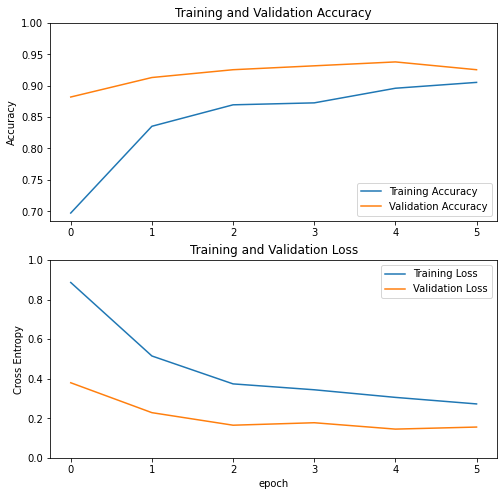

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Traineren des Modells: Fine-Tuning
Nun wird eingestellt, dass auch die Gewichte des Basis-Modells trainiert werden können. Jedoch nur mit geringer Lernrate

In [32]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy',f1_m,precision_m, recall_m]
)

history = model.fit(training_set, epochs=3, validation_data=val_dataset)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1536)              0   

Zeigen der Loss und Accuracy-Werte während den Epochen fürs Fine-Tuning

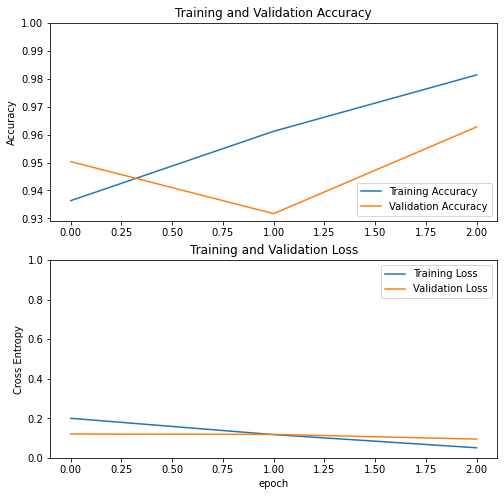

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Bestimmen der Klasse eines Bildes mithilfe des trainerten Modells

In [34]:
import cv2
import numpy as np
def load(filename):
   np_image = cv2.imread(filename)
   np_image = cv2.resize(np_image, (150, 150))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('weiss.JPG')
#0: Dosenoeffner   1:Flaschenoeffner   2:Korkenzieher
model.predict(image)

array([[5.68739313e-04, 9.99417901e-01, 1.33421645e-05]], dtype=float32)